# Notebook - Modelo Falta

In [15]:
import polars as pl
import matplotlib.pyplot as plt
from datetime import datetime
from random import randint, uniform

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import pickle

from imblearn.under_sampling import RandomUnderSampler

import spacy

In [16]:
path_data = "../documents/base dados/"

## Carregando as bases

In [17]:
df_diarioFreq = (
    pl.read_csv(path_data + "TbDiario/Originais anonimizados/TbDiarioFrequencia.csv")
    .select(
        pl.col("IdDiarioAula").alias("id_diario_aula"),
        pl.col("IdAluno").alias("id_aluno"),
        pl.when(
            pl.col("StPresencaFalta") == "P"
        ).then(1).otherwise(0).alias("presente"),
    )
)

df_diarioFreq.sample(5)

id_diario_aula,id_aluno,presente
i64,i64,i32
22125,386,1
968,426,1
18257,1468,1
20395,459,1
806,231,1


In [18]:
df_diarioAula = (
    pl.read_csv(path_data + "TbDiario/Originais anonimizados/TbDiarioAula.csv", ignore_errors=True)
    .select(
        pl.col("IdDiarioAula").alias("id_diario_aula"),
        pl.col("IdDiario").alias("id_diario"),
        pl.col('DataAula').str.strptime(pl.Date, "%Y-%m-%d %H:%M:%S").alias("data_aula"),
        pl.col("NumeroAula").alias("num_aula"),
        pl.col("ConteudoMinistrado").alias("conteudo_ministrado"),
        pl.col("IdProfessor").alias("id_professor")
    )
    .with_columns(
        pl.col("data_aula").dt.weekday().alias("dia_semana")
    )
    .to_dummies("dia_semana")
    .sort(["data_aula", "num_aula"])
)

df_diarioAula

id_diario_aula,id_diario,data_aula,num_aula,conteudo_ministrado,id_professor,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,dia_semana_7
i64,i64,date,i64,str,i64,u8,u8,u8,u8,u8,u8,u8
998,201,2021-07-01,1,"""Árvore da bondade.""",14,0,0,0,1,0,0,0
1575,115,2021-07-01,1,"""Apresentação dos princípios.""",14,0,0,0,1,0,0,0
1548,103,2021-07-01,1,"""Apresentação dos princípios.""",14,0,0,0,1,0,0,0
1554,106,2021-07-01,1,"""Apresentação dos princípios.""",14,0,0,0,1,0,0,0
1030,219,2021-07-01,1,"""Árvore da bondade.""",14,0,0,0,1,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…
25069,2632,2024-06-28,9,"""correção da prova e exercicios…",34,0,0,0,0,1,0,0
25068,2637,2024-06-28,9,"""correção da prova e exercicios…",34,0,0,0,0,1,0,0
25257,2418,2024-06-28,9,"""Correção da Avaliação P2""",35,0,0,0,0,1,0,0


In [19]:
df_diario = (
    pl.read_csv(path_data + "TbDiario/Originais anonimizados/TbDiario.csv", ignore_errors=True)
    .select(
        pl.col("IdDiario").alias("id_diario"),
        pl.col("IdTurma").alias("id_turma"),
        pl.col("IdDisciplina").alias("id_disciplina")
    )
)

df_diario.sample(5)

id_diario,id_turma,id_disciplina
i64,i64,i64
1279,471,19
676,169,19
200,70,1
1721,505,25
1732,542,5


In [20]:
df_turma = (
    pl.read_csv(path_data + "TbTurma/Originais anonimizados/TbTurma.csv", ignore_errors=True)
    .select(
        pl.col("IdTurma").alias("id_turma"),
        pl.col("IdSerie").alias("id_serie"),
        pl.col("IdPeriodo").alias("id_periodo"),
        pl.col('TurnoPrincipal').replace_strict(
            {"M": 0, "T": 1, "N": 2, "Z": 3}, default = 4
        ).alias("turno_turma")
    )
)

df_turma.sample(5)

id_turma,id_serie,id_periodo,turno_turma
i64,i64,i64,i64
516,25,6,0
601,54,6,2
300,54,5,2
453,32,5,4
409,24,5,0


In [21]:
df_aluno = (
    pl.read_csv(path_data + "TbAluno/Originais anonimizados/TbAluno.csv", ignore_errors=True)
    .select(
        pl.col("IdAluno").alias("id_aluno"),
        pl.col("DataNascimento").str.strptime(pl.Date, "%Y-%m-%d %H:%M:%S", strict=False).alias("data_nascimento_aluno"),
        pl.col("Sexo").replace_strict(
            {"M": 0, "F": 1}
        ).alias("sexo_aluno"),
        pl.when(
            pl.col("IdPai").is_null()
        ).then(0).otherwise(1).alias("tem_pai"),
        pl.when(
            pl.col("IdMae").is_null()
        ).then(0).otherwise(1).alias("tem_mae"),
        pl.col("CorRaca").fill_null("None").alias("raca_aluno"),

    )
    .with_columns(
        (datetime.now().year - pl.col("data_nascimento_aluno").dt.year()).alias("idade_aluno")
    )
    .to_dummies(['raca_aluno'])
)

df_aluno.sample(5)

id_aluno,data_nascimento_aluno,sexo_aluno,tem_pai,tem_mae,raca_aluno_A,raca_aluno_B,raca_aluno_I,raca_aluno_N,raca_aluno_None,raca_aluno_P,raca_aluno_R,idade_aluno
i64,date,i64,i32,i32,u8,u8,u8,u8,u8,u8,u8,i32
1362,2014-11-13,1,0,0,0,1,0,0,0,0,0,10
2011,2016-01-19,1,1,0,0,1,0,0,0,0,0,8
1119,2004-08-03,0,0,1,0,0,0,0,0,0,1,20
673,2013-11-30,0,0,1,0,0,0,0,0,1,0,11
2259,2009-10-21,0,0,0,0,0,0,1,0,0,0,15


In [22]:
df_professor = (
    pl.read_csv(path_data + "TbProfessor/Originais anonimizados/TbProfessor.csv", ignore_errors=True)
    .select(
        pl.col("IdProfessor").alias("id_professor"),
        pl.col("DataNascimento").str.strptime(pl.Date, "%Y-%m-%d %H:%M:%S", strict=False).alias("data_nascimento_professor"),
        pl.col("Sexo").replace_strict(
            {"M": 0, "F": 1}
        ).alias("sexo_professor"),
        pl.col("CorRaca").alias("raca_professor"),
        pl.col('Cargo').fill_null("Nenhum").alias("cargo_professor")
    )
    .with_columns(
        (datetime.now().year - pl.col("data_nascimento_professor").dt.year()).alias("idade_professor")
    )
    .to_dummies(['raca_professor', 'cargo_professor'])
)

df_professor.sample(5)


id_professor,data_nascimento_professor,sexo_professor,raca_professor_A,raca_professor_B,raca_professor_N,raca_professor_P,raca_professor_R,cargo_professor_Nenhum,cargo_professor_Neuropsicóloga,cargo_professor_Professor,cargo_professor_Professor Inglês,cargo_professor_Professor de Inglês,cargo_professor_Professor de Matemática,cargo_professor_Professora,cargo_professor_Professora de Inglês,cargo_professor_Professora de Matemática,cargo_professor_Professora/Coordenadora,cargo_professor_Psicóloga,cargo_professor_Psicólogo,cargo_professor_professora,idade_professor
i64,date,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i32
25,1985-06-20,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,39
17,1968-07-18,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,56
27,2004-12-24,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,20
15,1981-03-12,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,43
40,2005-02-20,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,19


## Merge das bases

In [23]:
df_raw = df_diarioFreq.join(df_aluno, on="id_aluno", how="left")
df_raw = df_raw.join(df_diarioAula, on="id_diario_aula", how="left")
df_raw = df_raw.join(df_professor, on="id_professor", how="left")
df_raw = df_raw.join(df_diario, on="id_diario", how="left")
df_raw = df_raw.join(df_turma, on="id_turma", how="left")

In [24]:
df = df_raw.select(
    #Aula
    pl.col('data_aula'),
    pl.col("dia_semana_1"),
    pl.col("dia_semana_2"),
    pl.col("dia_semana_3"),
    pl.col("dia_semana_4"),
    pl.col("dia_semana_5"),
    pl.col("dia_semana_6"),
    pl.col("dia_semana_7"),
    pl.col('num_aula'),
    pl.col('conteudo_ministrado'),
    #Aluno
    pl.col('id_aluno'),
    pl.col('sexo_aluno'),
    pl.col('tem_pai'),
    pl.col('tem_mae'),
    pl.col("raca_aluno_A"),
    pl.col("raca_aluno_B"),
    pl.col("raca_aluno_I"),
    pl.col("raca_aluno_N"),
    pl.col("raca_aluno_None"),
    pl.col("raca_aluno_P"),
    pl.col("raca_aluno_R"),
    pl.col('idade_aluno'),
    #Professor
    pl.col('id_professor'),
    pl.col('sexo_professor'),
    pl.col("raca_professor_A"),
    pl.col("raca_professor_B"),
    pl.col("raca_professor_N"),
    pl.col("raca_professor_P"),
    pl.col("raca_professor_R"),
    pl.col("cargo_professor_Nenhum"),
    pl.col("cargo_professor_Neuropsicóloga"),
    pl.col("cargo_professor_Professor"),
    pl.col("cargo_professor_Professor Inglês"),
    pl.col("cargo_professor_Professor de Inglês"),
    pl.col("cargo_professor_Professor de Matemática"),
    pl.col("cargo_professor_Professora"),
    pl.col("cargo_professor_Professora de Inglês"),
    pl.col("cargo_professor_Professora de Matemática"),
    pl.col("cargo_professor_Professora/Coordenadora"),
    pl.col("cargo_professor_Psicóloga"),
    pl.col("cargo_professor_Psicólogo"),
    pl.col("cargo_professor_professora"),
    pl.col('idade_professor'),
    #Turma
    pl.col('id_turma'),
    pl.col('id_disciplina'),
    pl.col('id_serie'),
    pl.col('id_periodo'),
    pl.col('turno_turma'),
    #Target
    pl.col('presente')
)

## Criando Safras e ABT
Olhando para as últimas 10 presenças de cada aluno, vamos criar uma target que será se o aluno faltou na presença seguinte ou não.

In [25]:
df_seq = df.sort('id_aluno', 'data_aula').with_columns(
    pl.col('data_aula').rank('ordinal').over('id_aluno').alias('seq_presenca')
)

In [33]:
def criar_abt(df, tamanho_janela=10, passo=1):

    nlp = spacy.load('pt_core_news_sm')

    def criar_embedding(texto):
        doc = nlp(texto)
        return doc.vector.tolist()

    max_seq = df['seq_presenca'].max()
    
    resultados = []
    for inicio_janela in range(1, max_seq - tamanho_janela + 2, passo):
        fim_janela = inicio_janela + tamanho_janela - 1

        df_janela = (
            df
            .sort('seq_presenca')
            .filter((pl.col('seq_presenca') >= inicio_janela) & 
                      (pl.col('seq_presenca') <= fim_janela))
            .group_by('id_aluno')
            .agg(

                #Coletando dados da aula
                pl.first('data_aula').alias('first_data_aula'),
                pl.last('data_aula').alias('last_data_aula'),
                pl.sum("dia_semana_1"),
                pl.sum("dia_semana_2"),
                pl.sum("dia_semana_3"),
                pl.sum("dia_semana_4"),
                pl.sum("dia_semana_5"),
                pl.sum("dia_semana_6"),
                pl.sum("dia_semana_7"),
                pl.col('conteudo_ministrado').str.concat(" ").alias('conteudo'),

                #Coletando dados do aluno
                pl.first('sexo_aluno').alias('sexo_aluno'),
                pl.first('tem_pai').alias('tem_pai'),
                pl.first('tem_mae').alias('tem_mae'),    
                pl.first("raca_aluno_A"),
                pl.first("raca_aluno_B"),
                pl.first("raca_aluno_I"),
                pl.first("raca_aluno_N"),
                pl.first("raca_aluno_None"),
                pl.first("raca_aluno_P"),
                pl.first("raca_aluno_R"),
                pl.mean('idade_aluno').alias('idade_aluno_media'),

                #Coletando dados do professor
                pl.sum('sexo_professor'),
                pl.sum("raca_professor_A"),
                pl.sum("raca_professor_B"),
                pl.sum("raca_professor_N"),
                pl.sum("raca_professor_P"),
                pl.sum("raca_professor_R"),
                pl.sum("cargo_professor_Nenhum"),
                pl.sum("cargo_professor_Neuropsicóloga"),
                pl.sum("cargo_professor_Professor"),
                pl.sum("cargo_professor_Professor Inglês"),
                pl.sum("cargo_professor_Professor de Inglês"),
                pl.sum("cargo_professor_Professor de Matemática"),
                pl.sum("cargo_professor_Professora"),
                pl.sum("cargo_professor_Professora de Inglês"),
                pl.sum("cargo_professor_Professora de Matemática"),
                pl.sum("cargo_professor_Professora/Coordenadora"),
                pl.sum("cargo_professor_Psicóloga"),
                pl.sum("cargo_professor_Psicólogo"),
                pl.sum("cargo_professor_professora"),
                pl.mean('idade_professor'),
                
                #verificando quantos professores diferentes o aluno teve aula
                pl.n_unique('id_professor').alias('num_professores'),

                #verificando quantas disciplinas diferentes o aluno teve
                pl.n_unique('id_disciplina').alias('num_disciplinas'),

                #verificando quantas series diferentes o aluno esteve presente
                pl.n_unique('id_serie').alias('num_series'),

                #verificando quantas turmas diferentes o aluno esteve presente
                pl.n_unique('id_turma').alias('num_periodos'),

                #quantas presenças o aluno teve
                pl.sum('presente').alias('num_presencas'),

                #quantas presenças totais houve no período
                pl.count('presente').alias('num_aulas'),

                #na ordem de presenças, qual foi a última que o aluno esteve presente
                pl.when(pl.col('presente') == 1)
                    .then(pl.col('seq_presenca'))
                    .otherwise(0)
                    .max()
                .alias('ultima_presenca')
            )
            .with_columns(
                pl.lit(fim_janela).alias('last_seq'),
                pl.col('conteudo').map_elements(criar_embedding, return_dtype=pl.List(pl.Float64())).alias('conteudo_embedding')
            )
        )

        next_presente = (
            df.filter(pl.col('seq_presenca') == fim_janela+1)
            .select(['id_aluno', 'presente'])
            .rename({'presente': 'next_presente'})
        )

        df_janela = df_janela.join(
            next_presente, 
            on=['id_aluno'], 
            how='left'
        )

        resultados.append(df_janela)

    return pl.concat(resultados)


In [36]:
abt = criar_abt(df_seq).filter(pl.col('next_presente').is_not_null()).sort('first_data_aula')

In [48]:
abt = abt.select(
    pl.all().exclude('conteudo', 'conteudo_embedding'),
    pl.col('conteudo_embedding').list.to_struct()
).unnest('conteudo_embedding')

abt

id_aluno,first_data_aula,last_data_aula,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,dia_semana_7,sexo_aluno,tem_pai,tem_mae,raca_aluno_A,raca_aluno_B,raca_aluno_I,raca_aluno_N,raca_aluno_None,raca_aluno_P,raca_aluno_R,idade_aluno_media,sexo_professor,raca_professor_A,raca_professor_B,raca_professor_N,raca_professor_P,raca_professor_R,cargo_professor_Nenhum,cargo_professor_Neuropsicóloga,cargo_professor_Professor,cargo_professor_Professor Inglês,cargo_professor_Professor de Inglês,cargo_professor_Professor de Matemática,cargo_professor_Professora,cargo_professor_Professora de Inglês,cargo_professor_Professora de Matemática,cargo_professor_Professora/Coordenadora,…,field_59,field_60,field_61,field_62,field_63,field_64,field_65,field_66,field_67,field_68,field_69,field_70,field_71,field_72,field_73,field_74,field_75,field_76,field_77,field_78,field_79,field_80,field_81,field_82,field_83,field_84,field_85,field_86,field_87,field_88,field_89,field_90,field_91,field_92,field_93,field_94,field_95
i64,date,date,i64,i64,i64,i64,i64,i64,i64,i64,i32,i32,u8,u8,u8,u8,u8,u8,u8,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
414,2021-07-01,2021-08-16,4,0,3,3,0,0,0,0,0,1,0,1,0,0,0,0,0,14.0,6,0,0,0,0,10,0,0,4,0,0,0,6,0,0,0,…,-1.018113,-0.915397,-0.854536,-1.382967,-1.147143,0.120368,1.300484,-0.739534,-1.850056,-0.49037,1.258377,-1.300593,1.741046,0.702875,-1.270327,0.106379,-0.177417,-0.52333,0.033219,1.795564,-1.884236,-0.104401,0.911591,-1.595252,1.23,0.523221,1.000842,0.739544,0.415443,-2.100062,1.278252,0.571613,-1.70248,1.252169,1.184306,-1.669529,-0.53963
277,2021-07-01,2021-08-17,1,5,0,1,3,0,0,1,0,1,0,1,0,0,0,0,0,15.0,10,0,3,0,0,7,0,0,0,0,0,0,7,0,0,0,…,-1.416316,-1.267669,-1.025146,-1.052947,-0.927343,0.15246,0.802768,-1.632859,-1.981035,-1.173149,-1.268965,-0.941859,1.594262,1.800248,-1.647881,-0.086848,-1.116361,-0.796242,0.196714,2.162737,-2.304278,0.138728,0.260063,-1.999932,1.332351,0.415358,0.916374,1.106958,0.465023,-2.634708,0.854546,-0.462938,-0.971118,2.405578,1.154716,-1.53277,-0.047658
685,2021-07-01,2021-08-17,1,4,2,3,0,0,0,0,0,1,0,0,0,0,0,0,1,10.0,10,0,6,0,0,4,0,0,0,0,0,0,10,0,0,0,…,-0.926215,-0.812829,-1.733077,-1.415712,-1.169233,-0.631945,1.179759,-0.721811,-1.790856,-1.187254,0.654051,-1.408938,1.405874,0.792844,-1.372881,-0.00298,-1.002307,-0.210204,0.196708,2.266593,-2.106193,-0.151892,0.856547,-1.311295,1.316081,0.383191,0.722475,0.862673,0.239915,-1.385053,0.972244,0.399762,-1.472526,2.326548,1.657062,-1.498753,-0.542094
691,2021-07-01,2021-08-17,0,7,0,3,0,0,0,1,0,1,0,0,0,0,0,0,1,11.0,10,0,6,0,0,4,0,0,0,0,0,0,10,0,0,0,…,-1.092061,-0.922953,-1.829483,-1.430711,-1.276028,-0.574729,1.129476,-0.758571,-1.907693,-1.184775,0.629042,-1.491869,1.572204,0.933222,-1.411159,-0.096745,-1.073789,-0.225886,0.14612,2.417267,-2.118229,-0.232279,0.857556,-1.293208,1.315706,0.422958,0.703387,0.785203,0.300146,-1.574851,1.04556,0.423745,-1.500185,2.236657,1.646614,-1.595921,-0.209151
426,2021-07-01,2021-08-17,4,3,2,1,0,0,0,1,0,1,0,1,0,0,0,0,0,13.0,10,0,3,0,0,7,0,0,0,0,0,0,10,0,0,0,…,-1.234138,-0.819188,-0.654271,-1.273103,-1.229966,0.609354,0.869892,-1.003088,-1.121814,-0.235215,0.721574,-1.055209,1.399281,1.169702,-1.522666,0.041631,-0.010223,-0.829811,0.150759,1.135764,-1.892164,-0.009362,1.190295,-1.325344,1.334385,0.561747,1.090777,0.63467,0.892515,-1.630622,1.308675,0.625943,-1.631508,2.045845,1.103302,-1.893464,-0.291509
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2180,2024-06-14,2024-06-26,4,0,4,0,2,0,0,1,1,0,0,1,0,0,0,0,0,17.0,8,0,8,0,0,2,3,0,0,0,0,0,3,2,0,2,…,-0.62567,-0.777788,-0.301498,-0.945252,-1.279137,0.691401,0.817376,-1.02332,-0.81614,-0.178529,0.933509,-0.982812,0.70214,0.833685,-1.375752,0.885888,-0.07,-1.5969

In [49]:
pickle.dump(abt, open("abt.pkl", "wb"))

### Modelagem - Separando Bases

In [50]:
abt_train = abt.filter(pl.col('first_data_aula') < datetime(2024, 1, 1))
abt_test = abt.filter(pl.col('first_data_aula') > datetime(2024, 1, 1))

In [51]:
X_train = abt_train.drop(['id_aluno', 'next_presente', 'first_data_aula', 'last_data_aula', 'last_seq'])
X_test = abt_test.drop(['id_aluno', 'next_presente', 'first_data_aula', 'last_data_aula', 'last_seq'])

y_train = abt_train['next_presente']
y_test = abt_test['next_presente']

In [52]:
X_train.shape, X_test.shape

((242702, 141), (49226, 141))

In [53]:
y_train.value_counts(normalize=True)

next_presente,proportion
i32,f64
1,0.768556
0,0.231444


In [54]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train.to_pandas(), y_train.to_pandas())

In [55]:
y_resampled.value_counts(normalize=True)

next_presente
0    0.5
1    0.5
Name: proportion, dtype: float64

In [56]:
y_resampled.shape

(112344,)

### Modelagem - Treinando Modelos

In [45]:
param_dist = {
   'n_estimators': [100, 200, 300, 600],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_cv = RandomizedSearchCV(
    estimator= RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(X_resampled, y_resampled)
best_rf = rf_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   7.5s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   9.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   9.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  14.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s

In [46]:
rf_cv.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 5}

In [57]:
best_rf = RandomForestClassifier(**{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 5,
 'random_state': 42}).fit(X_resampled, y_resampled)

In [58]:
y_pred = best_rf.predict(X_test)
    
# Gerar e imprimir o relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.46      0.23      0.31      7067
           1       0.88      0.96      0.92     42159

    accuracy                           0.85     49226
   macro avg       0.67      0.59      0.61     49226
weighted avg       0.82      0.85      0.83     49226



In [63]:
#feature importance
feature_importance = pd.DataFrame(
    best_rf.feature_importances_,
    index=X_train.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

feature_importance.head(25)

,importance
num_presencas,0.431336
ultima_presenca,0.120551
idade_aluno_media,0.052691
cargo_professor_Nenhum,0.041741
tem_pai,0.029789
cargo_professor_Psicóloga,0.025580
num_disciplinas,0.021055
cargo_professor_Professor,0.019518
tem_mae,0.018542
num_professores,0.010325


In [64]:
dict_model = {
    'model': best_rf,
    'cols': X_train.columns
}

In [65]:
pickle.dump(dict_model, open('../app/backend/model/model.pkl', 'wb'))

## Explorar

In [121]:
df['conteudo_ministrado'].value_counts().sort('count', descending=True)

conteudo_ministrado,count
str,u32
"""Autoconhecimento """,1378
"""Autoconhecimento""",1206
"""Prova P2""",892
"""Sentimentos e emoções""",873
"""Atividades de estimulação cogn…",782
…,…
"""Diagnostic test - P4""",3
"""AVALIAÇÃO DIAGNÓSTICA- SEGUNDO…",1
"""homework - review for the test…",1


<BarContainer object of 551 artists>

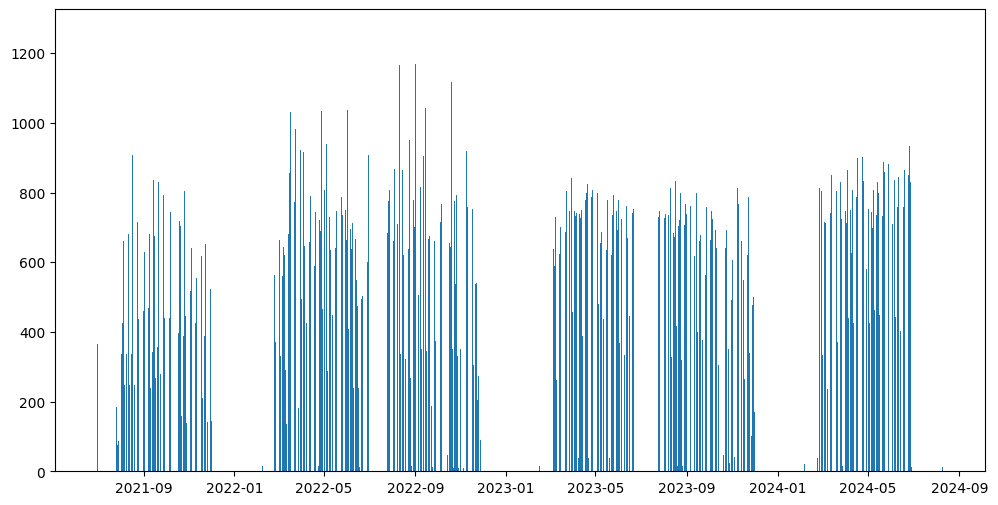

In [122]:
data_aulas = df.group_by('data_aula').len().sort('data_aula')

plt.figure(figsize=(12, 6))
plt.bar(data_aulas['data_aula'], data_aulas['len'])